# Denoising Diffusion Probabilistic Models with miniai

In [1]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

Generating test split: 100%|██████████| 10000/10000 [00:01<00:00, 5328.78 examples/s]


In [4]:
dt = dls.train
xb,yb = next(iter(dt))

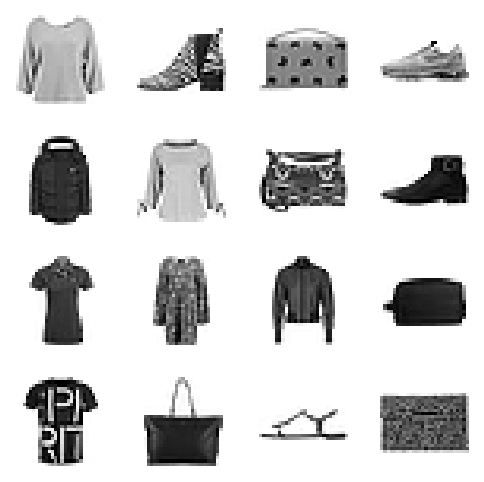

In [5]:
show_images(xb[:16], imsize=1.5)

In [6]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

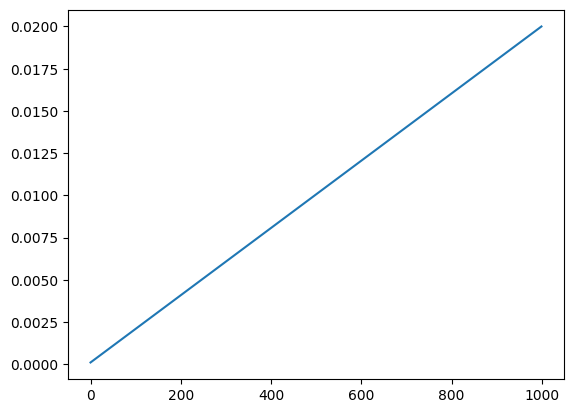

In [7]:
plt.plot(beta);

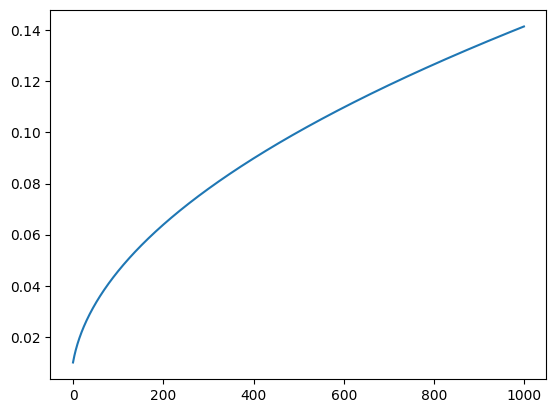

In [8]:
plt.plot(sigma);

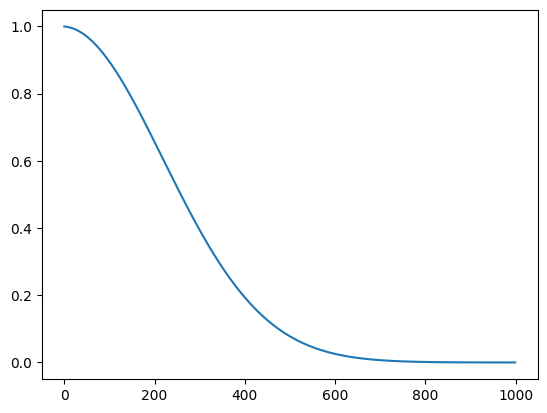

In [9]:
plt.plot(alphabar);

In [7]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt() * x0 + (1. - ᾱ_t).sqrt() * ε
    return (xt, t.to(device)), ε

In [8]:
(xt, t), ε = noisify(xb[:25], alphabar)
t

tensor([106, 573,  96, 732, 741, 778,  32, 545, 516, 872, 793, 552, 799, 593,
        867, 305, 146,  55, 901, 631, 352, 159,  84, 242,  63])

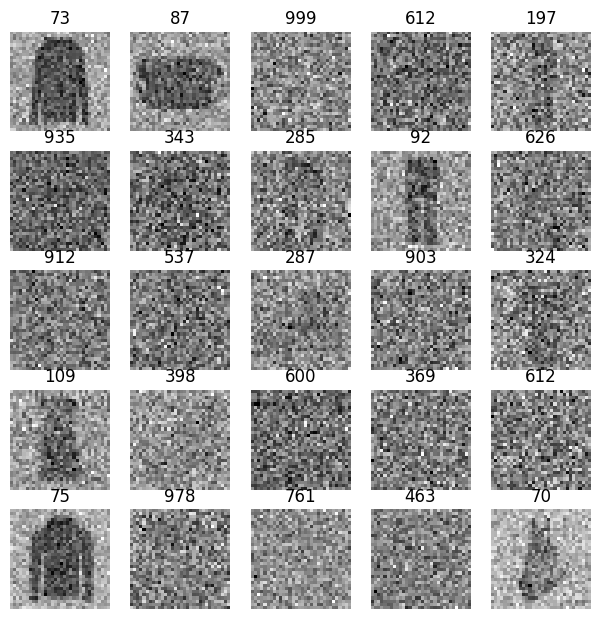

In [8]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

## Training

In [9]:
from diffusers import UNet2DModel

In [13]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - alphabar[t-1]
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch))) / alphabar[t].sqrt()).clamp(-1, 1)
        x_t = x_0_hat * ᾱ_t1.sqrt() * (1 - alpha[t]) / b̄_t + x_t * alpha[t].sqrt() * b̄_t1 / b̄_t + sigma[t] * z
        preds.append(x_t.cpu())
    return preds

In [14]:
# @torch.no_grad()
# def sample(model, sz, alpha, alphabar, sigma, n_steps):
#     device = next(model.parameters()).device
#     x_t = torch.randn(sz, device=device)
#     preds = []
#     for t in reversed(range(n_steps)):
#         t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
#         z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
#         ᾱ_t1 = alphabar[t-1] if t > 0 else torch.tensor(1)
#         b̄_t = 1 - alphabar[t]
#         b̄_t1 = 1 - ᾱ_t1
#         x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch))) / alphabar[t].sqrt()).clamp(-1, 1)
#         x_t = x_0_hat * ᾱ_t1.sqrt() * (1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
#         preds.append(x_t.cpu())
#     return preds

In [17]:
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.ᾱ)
    def sample(self, model, sz): return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)


In [18]:
# TODO check the docstring is right on this
class UNet(UNet2DModel):
    """UNet that takes a tuple as input and returns a single output"""
    def forward(self, x): return super().forward(*x).sample

In [19]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

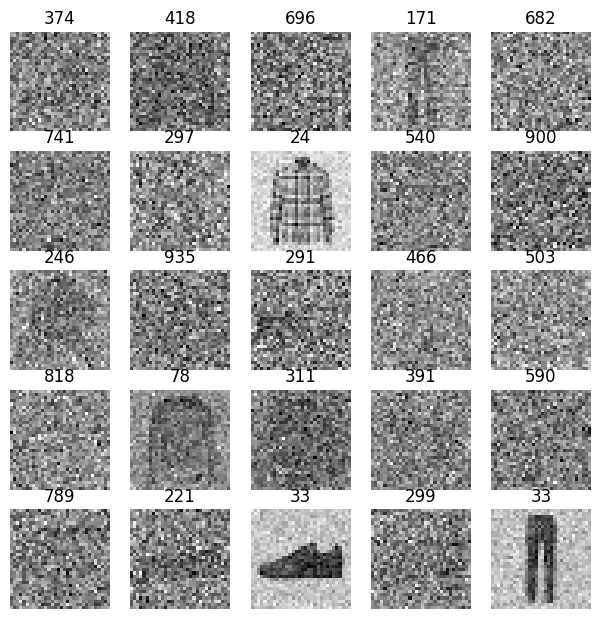

In [20]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb, SingleBatchCB()])
(xt, t), ε = learn.batch
show_images(xt[:25], imsize=1.5, titles=fc.map_ex(t[:25], '{}'))

In [21]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [23]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

In [24]:
model

UNet(
  (conv_in): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=16, out_features=64, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=64, out_features=64, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=64, out_features=16, bias=True)
          (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (

In [25]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
        for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [26]:
init_ddpm(model)

In [27]:
opt_func = partial(optim.Adam, eps=1e-5)

In [28]:
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.148,0,train
0.027,0,eval
0.023,1,train
0.022,1,eval
0.020,2,train
0.020,2,eval
0.019,3,train
0.019,3,eval
0.018,4,train
0.018,4,eval


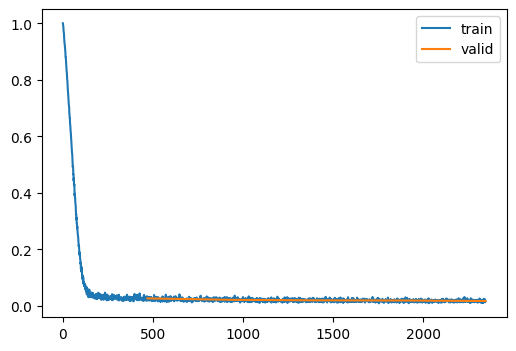

In [29]:
learn.fit(epochs)

In [36]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'fashion_ddpm2.pkl')

In [37]:
learn.model = torch.load(mdl_path/'fashion_ddpm2.pkl')

## Sampling

In [38]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

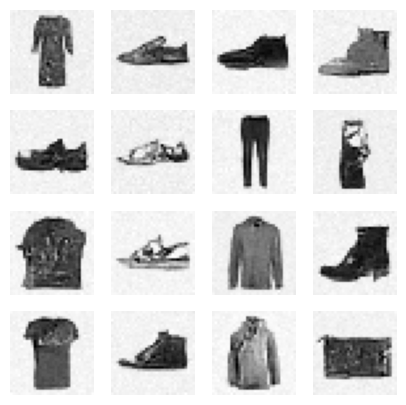

In [39]:
show_images(samples[-1], figsize=(5,5))

## Mixed Precision

In [40]:
bs = 512

In [41]:
next(iter(DataLoader(tds['train'], batch_size=2)))

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0])}

In [42]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds): return DataLoader(ds, bs, num_workers=fc.defaults.cpus, collate_fn=collate_ddpm)

In [43]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [44]:
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10

    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()
    
    def after_loss(self, learn): self.autocast.__exit__(None, None, None)

    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()


In [45]:
lr = 1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.264,0,train
0.033,0,eval
0.029,1,train
0.031,1,eval
0.024,2,train
0.025,2,eval
0.022,3,train
0.023,3,eval
0.020,4,train
0.020,4,eval


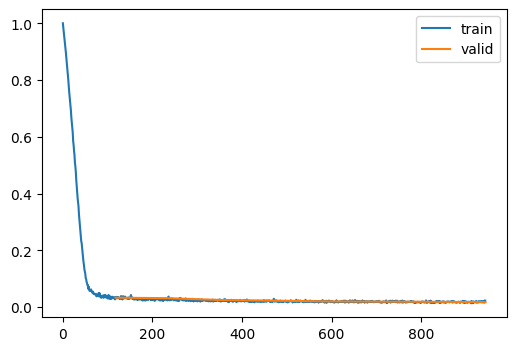

In [27]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/fashion_ddpm_mp.pkl')

## Accelerate (HF)

In [54]:
from accelerate import Accelerator

In [61]:
class AccelerateCB(TrainCB):
    order = DeviceCB.order + 10

    def __init__(self, n_inp=1, mixed_precision='fp16'):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)

    def before_fit(self, learn):
        learn.model, learn.opt, learn.dls.train, learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)
        
    def backward(self, learn): self.acc.backward(learn.loss)

In [62]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

In [68]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [69]:
# deal with HF love for dicts
class DDPMCB2(Callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

In [70]:
# now we're just using the standard UNet2DModel 
# -- not really any benefit to this approach vs the previous one, but maybe it's more flexible?
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.270,0,train
0.034,0,eval
0.030,1,train
0.029,1,eval
0.024,2,train
0.023,2,eval
0.022,3,train
0.022,3,eval
0.020,4,train
0.020,4,eval


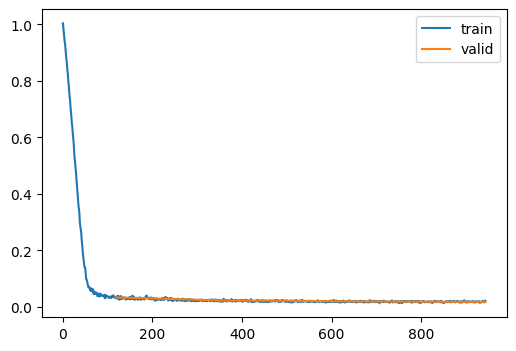

In [71]:
learn.fit(epochs)

## A sneaky trick

If the data loading is slowing down training (e.g. can't max out gpu with our small model) we can reuse the same data for a few batches. 

There's still grad updates inbetween so it's still beneficial

In [72]:
class MultiDL:
    def __init__(self, dl, mult=2): self.dl, self.mult = dl, mult
    def __len__(self): return len(self.dl) * self.mult
    def __iter__(self):
        for o in self.dl:
            for _ in range(self.mult): yield o

In [73]:
dls.train = MultiDL(dls.train, 2)